# Natural images CT Inverse problems with Gaussian Noise


In [17]:
#For plotting and importing images from directories
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Deep inverse imports
import deepinv as dinv
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.models import DnCNN, DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder


torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"


torch.Size([3, 64, 64])

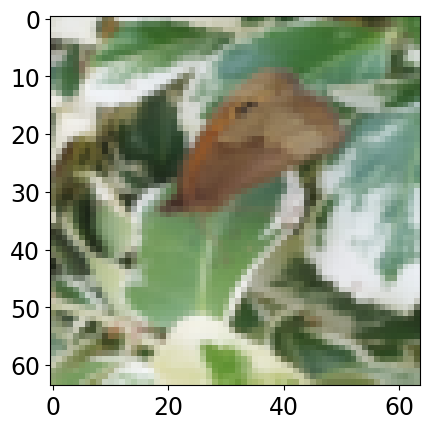

In [153]:
path = "data/butterfly.png"
image = Image.open(path)
#image = image.convert('L')
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(),])
img = transform(image)
plt.imshow(img.permute(1, 2, 0))
img.shape

C:\Users\as5057\AppData\Local\Temp\ipykernel_25192\17910107.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x1, device=device, dtype=torch.float)


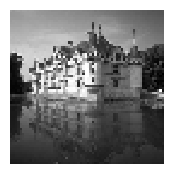

In [154]:
url = get_image_url("CBSD_0010.png")
imsize = (64, 64)
x1 = load_url_image(url, grayscale = True).to(device)
x = torch.tensor(x1, device=device, dtype=torch.float)
x = torch.nn.functional.interpolate(x, size= imsize)
img_size = x.shape[1:]

plot(x)

# Radon Transform with Gaussian noise


In [141]:
noise_level = 0.1
radon = dinv.physics.Tomography(
    img_width = img_size[-1],
    angles = 100,
    device = device,
    noise_model = dinv.physics.GaussianNoise(sigma = noise_level)
)

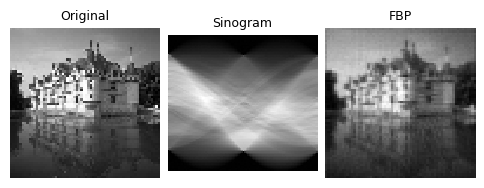

In [142]:
y = radon(x)
fbp = radon.A_dagger(y)
plot([x, y, fbp], titles = ["Original", "Sinogram", "FBP"])

In [ ]:
img = x.permute(1, 2, 0).numpy()
plt.imshow(img)

In [162]:
params = {"stepsize": 0.01, "lambda": 1e-3, "g_param": noise_level}

max_iter = 100
channels = 1
forward = L2()

# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)

# Classical priors
tvprior = dinv.optim.prior.TVPrior(n_it_max = max_iter)
bm3dprior = dinv.models.BM3D()


In [144]:
priorbm3d = PnP(denoiser = bm3dprior)
prior1 = PnP(denoiser = dncnn)
prior2 = PnP(denoiser = drunet)


In [156]:
params2 = {"stepsize": 0.01, "lambda": 1e-4, "g_param": noise_level}
params3 = {"stepsize": 0.01, "lambda": 1e-3, "g_param": noise_level}
params4 = {"stepsize": 0.01, "lambda": 1e-2, "g_param": noise_level}


In [157]:
yv2 = optim_builder(
    iteration="PGD",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params2,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

tv3 = optim_builder(
    iteration="PGD",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params3,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

tv4 = optim_builder(
    iteration="PGD",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params4,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)



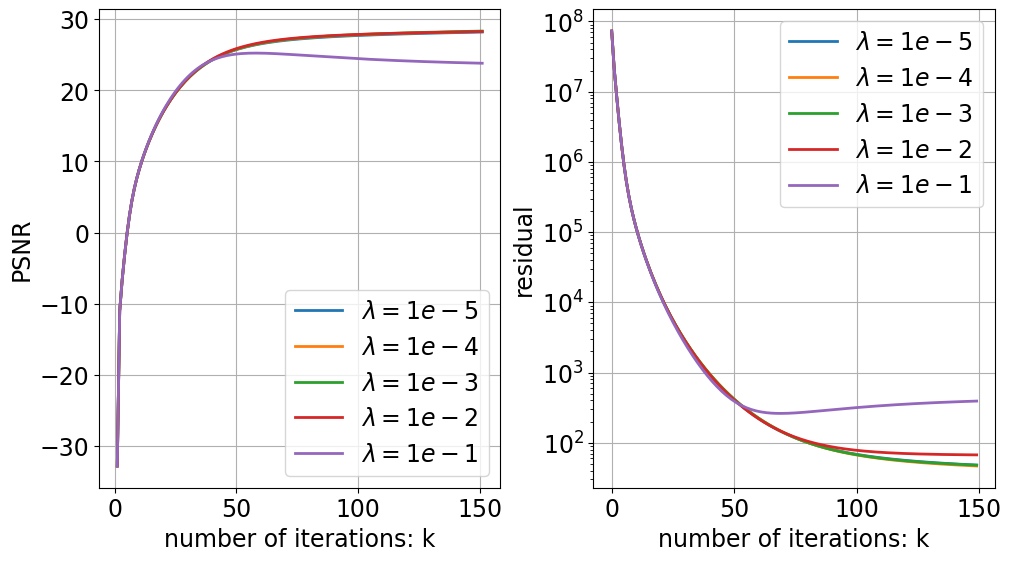

In [163]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
def plot_psnrs_residuals(lists, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """


    psnrs = list(lists.values())[0]
    residuals = list(lists.values())[1]
    psnrs = np.array(psnrs).flatten()
    residuals = np.array(residuals).flatten()
    #fig.suptitle(method)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(residuals, label = method)
    ax2.set_ylabel('residual')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)



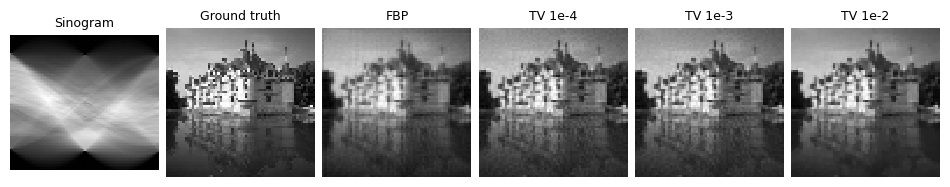

In [168]:
imgs = [y, x, fbp, tv_2, tv_3, tv_4]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "TV 1e-4", "TV 1e-3"])

In [170]:
# noise level parameters for drunet

paramsa = {"stepsize": 0.01, "lambda": 1e-3, "g_param": 0.1}
paramsb = {"stepsize": 0.01, "lambda": 1e-3, "g_param": 1}
paramsc = {"stepsize": 0.01, "lambda": 1e-3, "g_param": 10}


d1 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=paramsa,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

d2 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=paramsb,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

d3 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=paramsc,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)



In [171]:
x_a, metricsa = d1(y, radon, x_gt = x, compute_metrics = True)
x_b, metricsb = d2(y, radon, x_gt = x, compute_metrics = True)
x_c, metricsc = d3(y, radon, x_gt = x, compute_metrics = True)

Iteration 30, current converge crit. = 7.44E-06, objective = 1.00E-05 
Iteration 9, current converge crit. = 1.44E-06, objective = 1.00E-05 


In [ ]:
imgs = [y, x, fbp, x_a, x_b, x_c]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "DRUNet 0.1", "DRUNet 1", "DRUNet 10"])

# Initialise models (TV, BM3D, DnCNN, DRUNet)

In [164]:
#tv
model1 = optim_builder(
    iteration="PGD",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

#DnCNN
model2 = optim_builder(
    iteration="PGD",
    prior= prior1,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
model3 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

modelbm3d = optim_builder(
    iteration="PGD",
    prior= priorbm3d,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

In [165]:
x_model1, metrics1 = model1(y, radon, x_gt = x, compute_metrics = True)
x_model2, metrics2 = model2(y, radon, x_gt = x, compute_metrics = True)
x_model3, metrics3 = model3(y, radon, x_gt = x, compute_metrics = True)
x_modelbm3d, metricsbm3d = modelbm3d(y, radon, x_gt = x, compute_metrics = True)

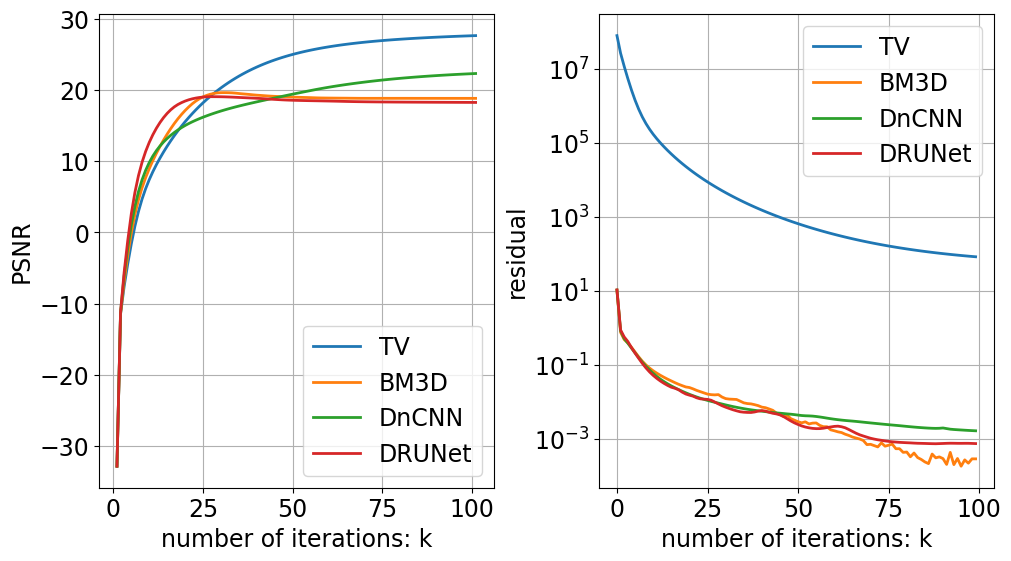

In [166]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
def plot_psnrs_residuals(lists, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """


    psnrs = list(lists.values())[0]
    residuals = list(lists.values())[1]
    psnrs = np.array(psnrs).flatten()
    residuals = np.array(residuals).flatten()
    #fig.suptitle(method)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(residuals, label = method)
    ax2.set_ylabel('residual')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)

plot_psnrs_residuals(metrics1, 'TV')
plot_psnrs_residuals(metricsbm3d, 'BM3D')
plot_psnrs_residuals(metrics2, 'DnCNN')
plot_psnrs_residuals(metrics3, 'DRUNet')

ax1.legend()
ax2.legend()


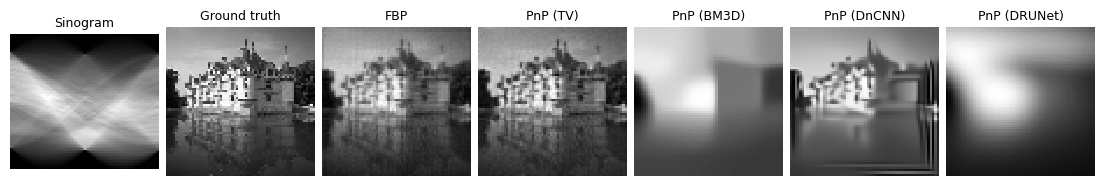

In [167]:
imgs = [y, x, fbp, x_model1, x_modelbm3d, x_model2, x_model3]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "PnP (TV)", "PnP (BM3D)", "PnP (DnCNN)", "PnP (DRUNet)"])

In [138]:
y.shape

torch.Size([1, 1, 40, 100])

In [149]:
def plt_ready(ground_truth, y, FBP, x_tv, x_bm3d, x_dncnn, x_drunet, imsize):
    sinogram = y.view(80, 100)
    gt = ground_truth.view(imsize)
    fbp = FBP.view(imsize)
    tv_x = x_tv.view(imsize)
    bm3d_x = x_bm3d.view(imsize)
    dncnn_x = x_dncnn.view(imsize)
    drunet_x = x_drunet.view(imsize)

    return sinogram, gt, fbp, tv_x, bm3d_x, dncnn_x, drunet_x

def plotting_estimates(gt, fbp, x1, x2, x3, x4):
    fig, axs = plt.subplots(2, 3, figsize=(10, 6.5))
    axs[0, 0].set_title("Ground Truth")
    axs[0, 0].imshow(gt, cmap='gray')
    axs[0, 1].set_title("FBP")
    axs[0, 1].imshow(fbp, cmap='gray')
    axs[0, 2].set_title("TV")
    axs[0, 2].imshow(x1, cmap='gray')
    axs[1, 0].set_title("BM3D")
    axs[1, 0].imshow(x2, cmap='gray')
    axs[1, 1].set_title("PnP (DnCNN)")
    axs[1, 1].imshow(x3, cmap='gray')
    axs[1, 2].set_title("PnP (DRUNet)")
    axs[1, 2].imshow(x4, cmap='gray')

    for i in range(2):
        for j in range(3):
            axs[i, j].axis('off')



imsize = (64, 64)


In [150]:
sinogram, ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet = plt_ready(x, y, fbp, x_model1, x_modelbm3d, x_model2, x_model3, imsize)
plt.imshow(sinogram, cmap = 'gray')
plt.title("Sinogram")
plt.xlabel("Projection angle")

RuntimeError: shape '[80, 100]' is invalid for input of size 9100

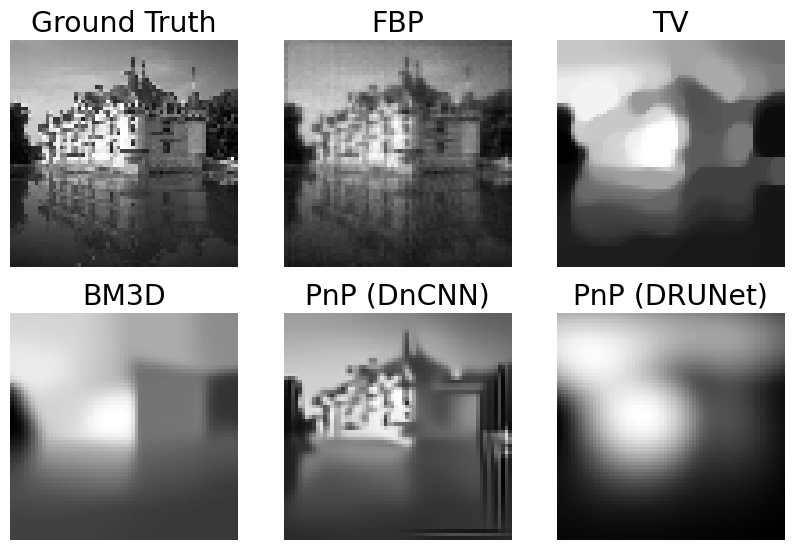

In [115]:
plotting_estimates(ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet)

# PnP-ADMM with the same priors

In [151]:
params = {"stepsize": 0.01, "lambda": 1, "beta": 1, "g_param": noise_level}
ADMM1 = optim_builder(
    iteration="ADMM",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

#DnCNN
ADMM2 = optim_builder(
    iteration="ADMM",
    prior= prior1,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
ADMM3 = optim_builder(
    iteration="ADMM",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

ADMMbm3d = optim_builder(
    iteration="ADMM",
    prior= priorbm3d,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


In [152]:
admm_model1, metrics_admm_1 = ADMM1(y, radon, x_gt = x, compute_metrics = True)
admm_model2, metrics_admm_2 = ADMM2(y, radon, x_gt = x, compute_metrics = True)
admm_model3, metrics_admm_3 = ADMM3(y, radon, x_gt = x, compute_metrics = True)
admm_modelbm3d, metrics_admm_bm3d = ADMMbm3d(y, radon, x_gt = x, compute_metrics = True)

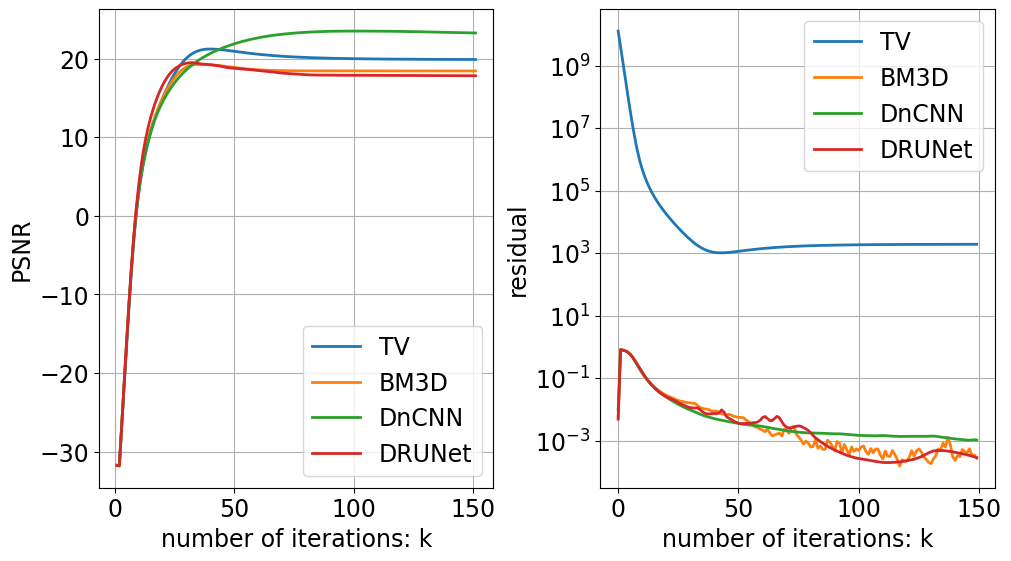

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
plot_psnrs_residuals(metrics_admm_1, 'TV')
plot_psnrs_residuals(metrics_admm_bm3d, 'BM3D')
plot_psnrs_residuals(metrics_admm_2, 'DnCNN')
plot_psnrs_residuals(metrics_admm_3, 'DRUNet')

ax1.legend()
ax2.legend()

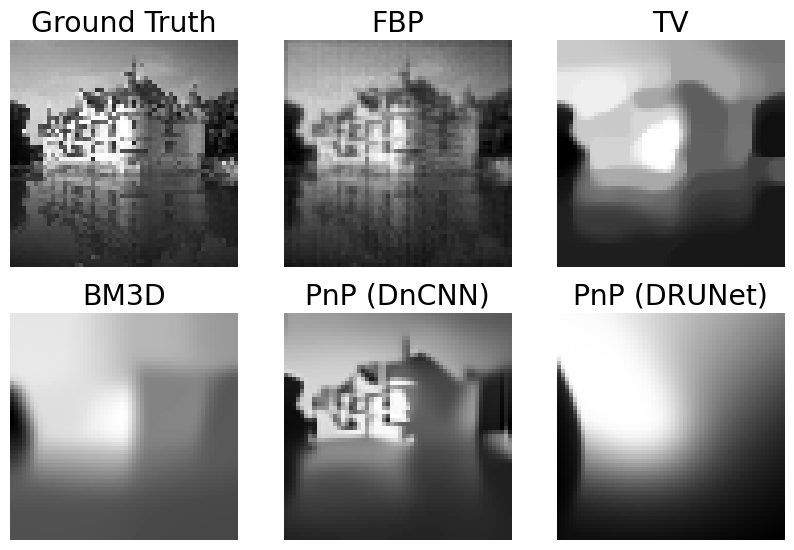

In [119]:
imsize = (56, 56)
sinogram, ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet = plt_ready(x, y, fbp, admm_model1, admm_modelbm3d, admm_model2, admm_model3, imsize)
plotting_estimates(ground_truth, FBP, x_tv, x_bm3d, x_dncnn, x_drunet)